In [102]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
import numpy as np 
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.impute import IterativeImputer
#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 50)


訓練データとテストデータの読み込み

In [103]:
train = pd.read_csv("../data/train.csv", index_col="id")
test = pd.read_csv("../data/test.csv", index_col="id")


In [104]:
train.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
id,,,,,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,12.518,15.748,19.292,11.739,20.155,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,11.540,17.717,17.893,12.748,17.889,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,11.652,16.738,18.240,12.718,18.288,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,11.188,18.576,18.339,12.583,19.060,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,12.950,16.990,15.746,11.306,18.093,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


In [105]:
test.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
id,,,,,,,,,,,,,,,,,,,,,,,,
26570,F,119.57,material_5,material_6,6,4,6,9,6,19.305,10.178,17.534,18.168,11.598,18.654,10.802,15.909,18.070,13.772,13.659,16.825,13.742,17.710,634.612
26571,F,113.51,material_5,material_6,6,4,11,8,0,17.883,11.927,17.228,16.033,11.179,19.368,12.032,13.998,NaN,12.473,17.468,16.708,14.776,14.102,537.037
26572,F,112.16,material_5,material_6,6,4,8,12,4,18.475,10.481,16.619,18.189,12.126,17.774,11.743,17.046,18.086,10.907,13.363,15.737,17.065,16.021,658.995
26573,F,112.72,material_5,material_6,6,4,8,11,10,16.518,10.888,15.293,18.592,11.304,18.948,11.790,18.165,16.163,10.933,15.501,15.667,12.620,16.111,594.301
26574,F,208.00,material_5,material_6,6,4,14,16,8,17.808,12.693,17.678,15.814,13.431,19.141,12.370,14.578,17.849,11.941,16.070,16.183,13.324,17.150,801.044


In [106]:
#訓練データとテストデータを結合させる

#訓練データとテストデータを識別するためのtrainラベルを訓練データとテストデータに付与する
train["train"] = True
test["train"] = False

#テストデータの目的変数を適当にセットする
test["failure"] = 99999

#訓練データとテストデータを結合
train_test = train.append(test)


False
False


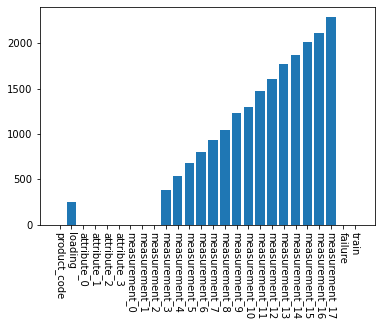

In [107]:
#欠損値がないか確認（nullが1つもなければ以下のprint文でTrueが出力される）
print(np.all(train.isnull().sum() == 0))
print(np.all(test.isnull().sum() == 0))

train_miss = train.isnull().sum()
plt.bar(train_miss.index, train_miss)
plt.xticks(rotation=270)
plt.show()


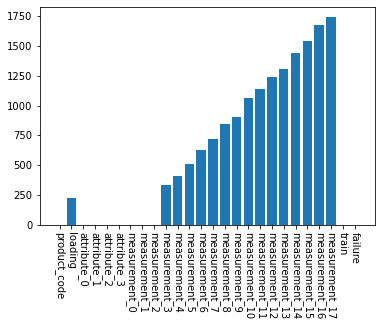

In [108]:
test_miss = test.isnull().sum()
plt.bar(test_miss.index, test_miss)
plt.xticks(rotation=270)
plt.show()


In [109]:
#欠損値補完（特徴量ごとの平均値を採用）
#train_test.fillna(train_test.mean(), inplace=True)

#欠損値がないか確認（nullが1つもなければTrueが出力される）
print(np.all(train_test.isnull().sum() == 0))

False


In [110]:

# IterativeImputerで欠損値補完
num_cols = [col for col in train_test.columns[:-1]
            if (train_test[col].dtypes == 'float64') or (train_test[col].dtypes == 'int64') and (col != "failure")]
print(num_cols)
for code in train_test['product_code'].unique():
    print(code)
    imputer = IterativeImputer(
        max_iter=8, random_state=0, skip_complete=True, n_nearest_features=12)
    train_test.loc[train_test['product_code'] == code, num_cols] = imputer.fit_transform(
        train_test.loc[train_test['product_code'] == code, num_cols])
print(np.all(train_test.isnull().sum() == 0))


['loading', 'attribute_2', 'attribute_3', 'measurement_0', 'measurement_1', 'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17']
A


c:\Users\keisu\anaconda3\envs\myenv2\lib\site-packages\sklearn\impute\_iterative.py:669: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


B


c:\Users\keisu\anaconda3\envs\myenv2\lib\site-packages\sklearn\impute\_iterative.py:669: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


C


c:\Users\keisu\anaconda3\envs\myenv2\lib\site-packages\sklearn\impute\_iterative.py:669: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


D


c:\Users\keisu\anaconda3\envs\myenv2\lib\site-packages\sklearn\impute\_iterative.py:669: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


E


c:\Users\keisu\anaconda3\envs\myenv2\lib\site-packages\sklearn\impute\_iterative.py:669: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


F


c:\Users\keisu\anaconda3\envs\myenv2\lib\site-packages\sklearn\impute\_iterative.py:669: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


G


c:\Users\keisu\anaconda3\envs\myenv2\lib\site-packages\sklearn\impute\_iterative.py:669: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


H


c:\Users\keisu\anaconda3\envs\myenv2\lib\site-packages\sklearn\impute\_iterative.py:669: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


I
True


c:\Users\keisu\anaconda3\envs\myenv2\lib\site-packages\sklearn\impute\_iterative.py:669: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


In [111]:
#ラベルエンコーディングを実施

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train_test["product_code"])
train_test["product_code"] = le.transform(train_test["product_code"])
le.fit(train_test["attribute_0"])
train_test["attribute_0"] = le.transform(train_test["attribute_0"])
le.fit(train_test["attribute_1"])
train_test["attribute_1"] = le.transform(train_test["attribute_1"])


In [112]:
#Onehotエンコーディングを実施
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False, drop='first')
col = ["attribute_0", "attribute_1", "attribute_2", "attribute_3"]
ohe.fit(train_test[col])
print(ohe.categories_)
ohe.fit(train_test[col])
print(ohe.categories_)

[array([0, 1]), array([0, 1, 2, 3]), array([5., 6., 7., 8., 9.]), array([4., 5., 6., 7., 8., 9.])]
[array([0, 1]), array([0, 1, 2, 3]), array([5., 6., 7., 8., 9.]), array([4., 5., 6., 7., 8., 9.])]


In [113]:
#特徴量追加

#mesurement3とmesurement5の欠損値の数
train_test['measurement_3_na'] = train_test['measurement_3'].isna().astype(int)
train_test['measurement_5_na'] = train_test['measurement_5'].isna().astype(int)

#attribute_2とattribute_3の積
train_test['attribute_2*3'] = train_test['attribute_2'] * train_test['attribute_3']

#['measurement_3', 'measurement_4', 'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16']の平均と分散
meas_gr1_cols = [f"measurement_{i:d}" for i in list(range(3, 5)) + list(range(9, 17))]
print(meas_gr1_cols)
train_test['meas_gr1_avg'] = np.mean(train_test[meas_gr1_cols], axis=1)
train_test['meas_gr1_std'] = np.std(train_test[meas_gr1_cols], axis=1)

#['measurement_5', 'measurement_6', 'measurement_7', 'measurement_8']の平均と分散
meas_gr2_cols = [f"measurement_{i:d}" for i in list(range(5, 9))]
print(meas_gr2_cols)
train_test['meas_gr2_avg'] = np.mean(train_test[meas_gr2_cols], axis=1)


['measurement_3', 'measurement_4', 'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16']
['measurement_5', 'measurement_6', 'measurement_7', 'measurement_8']


In [114]:
#訓練データとテストデータを再分割（数値データの標準化前にやっておかないといけない）

train = train_test[train_test["train"] == True]
train= train.drop(["train"], axis = 1)

test = train_test[train_test["train"] == False]
test= test.drop(["train", "failure"], axis = 1)

In [115]:
#データを標準化する列を抽出（数値変数のみ）
cols = [col for col in train.columns if train[col].dtypes == 'float64']

train[cols] = (train[cols] - train[cols].mean()) / train[cols].std(ddof=0)
test[cols] = (test[cols] - test[cols].mean()) / test[cols].std(ddof=0)


In [116]:
train

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure,measurement_3_na,measurement_5_na,attribute_2*3,meas_gr1_avg,meas_gr1_std,meas_gr2_avg
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,-1.228619,1,3,1.525966,-1.538285,-0.101025,-0.055370,-0.681939,0.249649,0.794713,-1.397102,1.808964,0.021811,1.129410,-0.775971,-0.188357,-1.063248,2.408745,-0.555073,-0.379258,-1.304746,-1.072564,0.506776,0,0,0,-0.273292,-0.713572,-1.802484,0.776864
1,0,-1.105309,1,3,1.525966,-1.538285,1.599402,-1.246039,-0.984141,0.423601,-0.193940,0.596808,0.388869,1.042594,-1.132415,1.039477,1.330531,-0.847003,0.037454,-0.819773,-0.431639,-0.400067,-0.501196,-0.157849,0,0,0,-0.273292,-0.264370,-1.089449,0.433755
2,0,-1.168637,1,3,1.525966,-1.538285,1.113565,-1.722306,-0.379737,0.266743,-0.080720,-0.394577,0.741101,1.012243,-0.734150,1.312407,-0.371671,0.680427,1.446572,0.943999,1.783208,-0.600147,0.895551,-0.309183,0,0,0,-0.273292,1.983187,-0.363697,0.302405
3,0,-0.688785,1,3,1.525966,-1.538285,1.356484,-1.484172,-0.077535,-0.499451,-0.549774,1.466675,0.841594,0.875667,0.036428,1.062988,0.165905,-0.535770,-1.159227,-0.358108,-0.336993,0.769169,0.428561,1.010508,0,0,0,-0.273292,-0.304093,-0.393849,1.587939
4,0,1.550610,1,3,1.525966,-1.538285,0.384811,-1.484172,0.526868,1.562836,1.231418,-0.139389,-1.790504,-0.416245,-0.928790,-1.118412,0.701298,0.511775,0.501642,0.472531,-2.272739,-1.225645,-0.029982,-0.985538,0,0,0,-0.273292,-0.125338,0.609514,-1.619903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26565,4,0.801228,1,1,-0.512321,1.208090,-0.343944,1.849699,-0.681939,-1.498921,1.543784,0.952249,-2.035138,-0.862395,0.329886,0.263735,-2.866778,-0.828814,-1.095772,0.127619,1.742448,0.762522,-0.443885,0.223494,0,0,0,0.621896,-0.810899,-0.380054,-0.792347
26566,4,0.468369,1,1,-0.512321,1.208090,0.627729,0.897164,0.526868,-0.250086,-0.993596,0.867186,1.591737,-0.585195,0.538501,-0.193310,-1.410450,0.937530,-1.011625,-1.071103,-1.193640,-1.230298,0.005615,1.234434,0,0,0,0.621896,-1.963624,0.716677,1.191391
26567,4,-0.314223,1,1,-0.512321,1.208090,-1.558534,0.420897,-1.588544,-2.133393,-0.198995,-0.354071,0.888288,-0.088461,0.255024,-0.024645,0.232101,-1.142741,-2.091742,-0.519423,0.379412,0.394269,-1.446035,0.395501,0,0,0,0.621896,-2.055504,-0.333385,0.346355


In [117]:
test

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,measurement_3_na,measurement_5_na,attribute_2*3,meas_gr1_avg,meas_gr1_std,meas_gr2_avg
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
26570,5,-0.207077,0,1,-1.325146,-1.145711,-0.340067,0.008674,-0.033091,1.520069,-1.545639,0.396176,0.657500,-0.114843,-0.377889,-0.627158,-0.140179,-0.499922,1.403247,-1.573964,0.512624,-0.918633,0.674821,-0.515794,0,0,-1.500282,-0.349423,0.427413,0.279948
26571,5,-0.362689,0,1,-1.325146,-1.145711,0.829695,-0.222055,-1.597307,0.090137,0.198773,0.090071,-1.492786,-0.537804,0.339957,0.623977,-1.389894,-0.608508,0.422967,1.311194,0.427144,-0.226627,-1.593189,-1.264254,0,0,-1.500282,-0.517642,-1.209209,-0.794321
26572,5,-0.397355,0,1,-1.325146,-1.145711,0.127838,0.700860,-0.554497,0.685439,-1.243433,-0.519138,0.678650,0.418149,-1.262629,0.330011,0.603371,-0.489627,-0.758803,-1.798171,-0.282260,1.305290,-0.386894,-0.328762,0,0,-1.500282,-0.599928,0.282919,-0.343789
26573,5,-0.382975,0,1,-1.325146,-1.145711,0.127838,0.470131,1.009719,-1.282477,-0.837501,-1.845591,1.084536,-0.411622,-0.082305,0.377819,1.335151,-1.727008,-0.739182,-0.178726,-0.333401,-1.669533,-0.330320,-0.825004,0,0,-1.500282,-1.691824,-0.687644,-0.629627
26574,5,2.063675,0,1,-1.325146,-1.145711,1.531552,1.623774,0.488314,0.014719,0.962763,0.540225,-1.713354,1.735486,0.111734,0.967784,-1.010598,-0.642128,0.021497,0.252267,0.043584,-1.198380,0.322802,0.760840,0,0,-1.500282,-0.350857,-1.464697,0.335013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47340,8,0.439251,1,0,0.967548,-0.624180,-1.743781,-1.144969,0.749016,0.675384,0.840086,1.008385,-0.429225,-0.512568,-0.459325,0.277117,0.003749,0.594610,-0.264512,1.143038,-0.724998,0.063159,0.611017,-0.041337,0,0,-0.203307,0.943877,-0.098314,-0.191609
47341,8,-1.363638,1,0,0.967548,-0.624180,-0.807972,-0.222055,0.227611,1.112810,-1.826899,1.150434,0.035473,0.035566,-1.118859,-0.446099,-0.063012,-2.028793,1.246282,-0.184028,-0.604451,-0.871785,-0.085163,-0.679662,0,0,-0.203307,-1.259655,-0.599736,0.053878
47342,8,-1.538252,1,0,0.967548,-0.624180,0.595742,0.470131,-1.075902,0.867449,0.266959,1.104418,0.397653,0.372723,0.603368,-0.999447,0.008923,1.135764,-0.587499,0.592366,-0.437145,-0.628847,0.686136,0.625109,0,0,-0.203307,0.354612,1.086759,1.235577


In [118]:
auc_list = []
test_pred_list = []
importance_list = []
kf = GroupKFold(n_splits=5)   # grouped by product_code

train_label = train["failure"]
train = train.drop(["failure"], axis=1)


In [119]:
for fold, (idx_tr, idx_va) in enumerate(kf.split(X=train, y=train_label, groups=train['product_code'])):
    X_tr = train.iloc[idx_tr]
    X_va = train.iloc[idx_va]
    y_tr = train_label.loc[idx_tr]
    y_va = train_label.loc[idx_va]
    
    # LR with GridSearch
    model = LogisticRegression(solver='liblinear', random_state=0)
    param_grid = {'C': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1], 'penalty':['l1','l2']}
    clf = GridSearchCV(model, param_grid, cv = 5, verbose = 0)
    print
    #clf = LogisticRegression(C=0.005, penalty='l1', solver='liblinear')
    
    clf.fit(X_tr, y_tr)
    #importance_list.append(clf.coef_.ravel())
    
    # Validate model
    va_preds = clf.predict_proba(X_va)[:,1]
    score = roc_auc_score(y_va, va_preds)
    print(f"Fold {fold}: auc = {score:.5f}")
    auc_list.append(score)
    
    # Test set predictions
    test_pred_list.append(clf.predict_proba(test)[:,1])
    
print(f'Average auc = {sum(auc_list) / len(auc_list):.5f}')
print('')
preds = sum(test_pred_list)/len(test_pred_list)


Fold 0: auc = 0.50000
Fold 1: auc = 0.50000
Fold 2: auc = 0.50000
Fold 3: auc = 0.50000
Fold 4: auc = 0.59337
Average auc = 0.51867



In [120]:
# My predictions
submission = pd.DataFrame({'id': test.index, 'failure': preds})

# Extract indexes
code_F = test[test['product_code'] == 'F'].index
code_GHI = test[test['product_code'] != 'F'].index

# Rank and scale
submission.loc[submission['id'].isin(code_GHI), 'failure'] = submission.loc[submission['id'].isin(
    code_GHI), 'failure'].rank() / submission.loc[submission['id'].isin(code_GHI), 'failure'].rank().max()



In [121]:
submission.to_csv("../submission/submission.csv", index=False)
